In [3]:
!pip install kaggle --quiet

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"koushik2k2","key":"ef16fbf8d9c9aa36cba78ef9cddebd2e"}'}

In [5]:
! mkdir ~/.kaggle


In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets list


ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          33141        901  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                               6KB  2023-05-28 18:26:48           4190        121  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                   22KB  2023-05-12 13:06:39           6294        131  1.0              
mohithsairamreddy/salary-data 

In [9]:
!kaggle datasets download -d pratik2901/animal-dataset

 97% 217M/225M [00:04<00:00, 67.3MB/s]
100% 225M/225M [00:04<00:00, 50.5MB/s]


In [10]:
!unzip animal-dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: animal_dataset_intermediate/train/farfalla_train/ee36b10b2bf41c22d2524518b7444f92e37fe5d404b0144390f8c770a2e9b5_640.jpg  
  inflating: animal_dataset_intermediate/train/farfalla_train/ee36b5092df01c22d2524518b7444f92e37fe5d404b0144390f8c770a2e9b5_640.jpg  
  inflating: animal_dataset_intermediate/train/farfalla_train/ef31b30f2de90021d85a5854ee454296eb70e3c818b413449df6c87fa7ee_640.jpg  
  inflating: animal_dataset_intermediate/train/farfalla_train/ef34b00e2ef31c22d2524518b7444f92e37fe5d404b0144390f8c770a2e9b5_640.jpg  
  inflating: animal_dataset_intermediate/train/farfalla_train/ef3db70e29f31c22d2524518b7444f92e37fe5d404b0144390f8c770a2e9b5_640.jpg  
  inflating: animal_dataset_intermediate/train/mucca_train/OIP---lAIbDlHKmejDpqrXq6vAAAAA.jpeg  
  inflating: animal_dataset_intermediate/train/mucca_train/OIP--8_E2EnxrYh7eym5nYRTJQHaE7.jpeg  
  inflating: animal_dataset_intermediate/train/mucca_train/OIP--DTVnqj-HKjAEvLxZyO

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.optimizers import SGD

In [13]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3   #rgb are channels
EPOCHS=9

In [14]:
data_dir =  "/content/animal_dataset_intermediate/train"

In [15]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 8196 files belonging to 5 classes.


In [16]:
class_names = dataset.class_names
class_names

['elefante_train',
 'farfalla_train',
 'mucca_train',
 'pecora_train',
 'scoiattolo_train']

In [17]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 0 0 1 4 1 2 0 3 1 4 4 3 2 4 1 3 1 0 1 2 4 3 0 1 4 2 3 0 1 3 0]


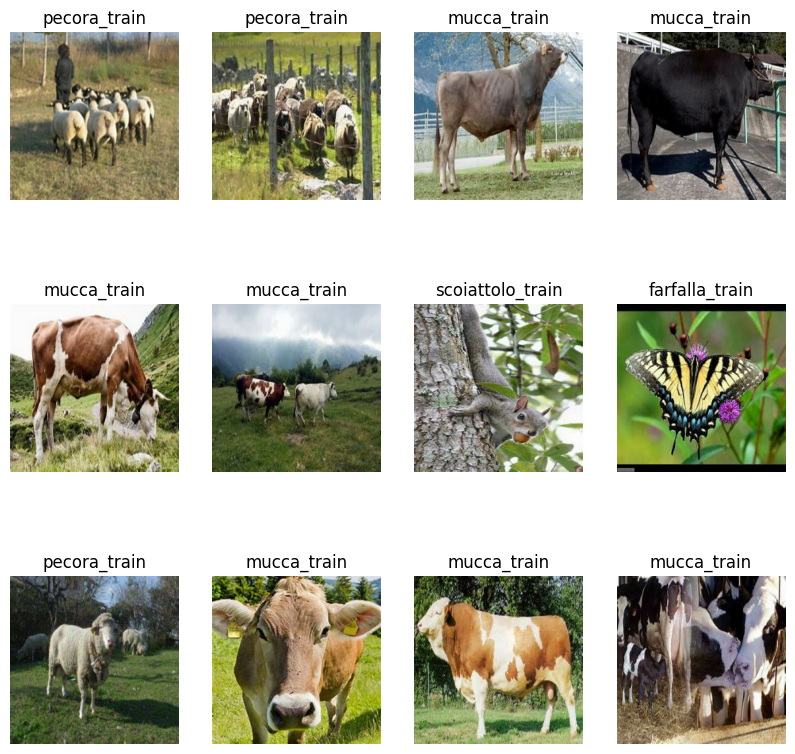

In [18]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [19]:
len(dataset)

257

In [20]:
train_size = 0.8   #80% for train 10%validate (to validate after ecah epochs) and 10% for test
len(dataset)*train_size

205.60000000000002

In [21]:
train_ds = dataset.take(25)
len(train_ds)

25

In [22]:
test_ds = dataset.skip(25)
len(test_ds)

232

In [23]:
val_size=0.1
len(dataset)*val_size

25.700000000000003

In [24]:
val_ds = test_ds.take(3)
len(val_ds)

3

In [25]:
test_ds = test_ds.skip(3)
len(test_ds)

229

In [26]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)   #seed for predictability

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [27]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [28]:
len(train_ds)

205

In [29]:
len(val_ds)

25

In [30]:
len(test_ds)

27

In [31]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# prefetch for improving performance and canche fo storing image in memory for easy going in epochs
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),   #this is resize layer
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [33]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),   #this is data-augumented layer
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [34]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
    #pooling-preserving th features and reducing the size
    # data_augmentation,
    # layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    # layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    # # layers.Conv2D(64, (3, 3), activation='relu'),
    # # layers.MaxPooling2D((2, 2)),
    # layers.Flatten(),
    # layers.Dense(64, activation='relu'),
    # layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (32, 246016)             

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    )

In [ ]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=9,
)


Epoch 1/9
205/205 [==============================] - ETA: 0s - loss: 1.7224 - accuracy: 0.3359

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:

history.history.keys()

In [ ]:
type(history.history['loss'])

In [ ]:
len(history.history['loss'])

In [ ]:
history.history['loss'][:5]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")